In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import urllib.request, json
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import geopandas as gp
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
%matplotlib inline

# Import data

In [2]:
somalia_map = gp.read_file('data/raw/gis/somalia_boundaries_admin1')
prmn        = pd.read_csv('data/clean/prmn_pairwise_admin1.csv', index_col=['date', 'src_region', 'dest_region'])

In [3]:
regions = ['Awdal', 'Bakool', 'Banadir', 'Bari', 'Bay', 'Galgaduud', 'Gedo',
           'Hiraan', 'Lower Juba', 'Lower Shabelle', 'Middle Juba',
           'Middle Shabelle', 'Mudug', 'Nugaal', 'Sool', 'Togdheer',
           'Woqooyi Galbeed', 'Sanaag']

# Network analysis

In [4]:
prmn = prmn.loc[:'2019-11-01']

## Build OD

In [5]:
# Make network df
nx_df = prmn[prmn.index.get_level_values('src_region').isin(regions) & prmn.index.get_level_values('dest_region').isin(regions)]
nx_df = nx_df.unstack(level='dest_region').fillna(0).stack()
nx_df.reset_index(inplace=True)

In [6]:
# Estimate in, out, and internal flows
idp = nx_df[nx_df.src_region==nx_df.dest_region][['src_region', 'dest_region','arrivals']].groupby('src_region').sum()
outflow = nx_df[['src_region', 'dest_region','arrivals']].groupby('src_region').sum()
inflow = nx_df[['src_region', 'dest_region','arrivals']].groupby('dest_region').sum()

In [7]:
idp.columns=['internal']
outflow.columns=['outflow']
inflow.columns=['inflow']

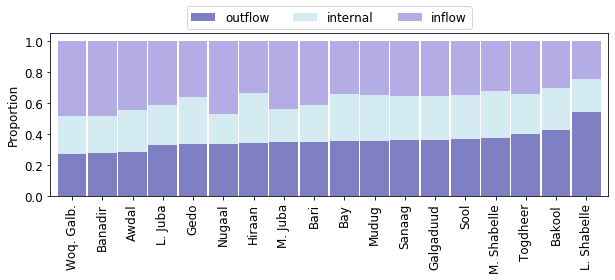

In [8]:
# Plot the distribution
all_flows = pd.concat([idp, outflow, inflow], axis=1, sort=True)

# Normalize
all_flows = all_flows.div(all_flows.sum(axis=1), axis=0)
all_flows.sort_values('outflow', inplace=True)

ax = all_flows[['outflow', 'internal', 'inflow']].plot(kind='bar', stacked=True, width=.95, figsize=[10,3], 
                                                color = ['darkblue', 'lightblue', 'slateblue'], alpha=0.5, fontsize=12)

ax.legend(loc="upper center", ncol=3, bbox_to_anchor=[0.5,1.2], fontsize=12)
ax.set_xticklabels([i.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in all_flows.index], fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
plt.savefig("figures/in_out_wide.png", dpi=100, bbox_inches="tight")

## Source and sink regions

In [9]:
somalia_map['centroid_x'] = somalia_map.geometry.centroid.x
somalia_map['centroid_y'] = somalia_map.geometry.centroid.y

In [10]:
somalia_map = somalia_map.merge(all_flows, left_on="admin1Name", right_index=True)

avg_arrivals = nx_df[['src_region', 'dest_region','arrivals', 'date']]
#avg_arrivals['arrivals'] = avg_arrivals['arrivals'].replace(0, np.nan)
avg_arrivals = avg_arrivals.groupby(['date','dest_region']).sum().groupby('dest_region').mean()
avg_arrivals.columns=['avg_arrivals']

somalia_map = somalia_map.merge(avg_arrivals, left_on="admin1Name", right_index=True)

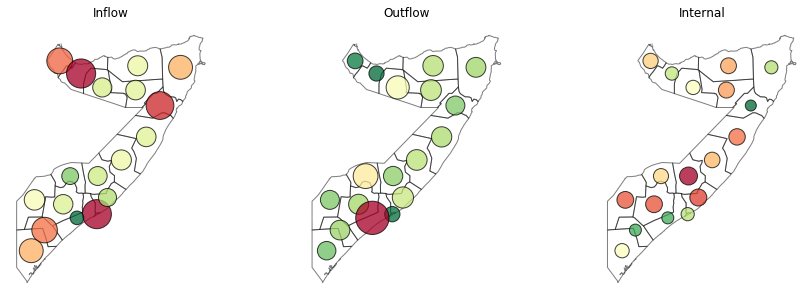

In [11]:
fig, ax = plt.subplots(1,3,figsize=[15,5])

cols =['inflow', 'outflow', 'internal']
for a in [0,1,2]:
    somalia_map.plot(ax=ax[a], color="None", edgecolor="black", alpha=0.5)

    pd.DataFrame(somalia_map).plot(x='centroid_x', y='centroid_y', kind='scatter', edgecolor="black", alpha=0.75,
                                   c=(somalia_map[cols[a]]), s=((2+somalia_map[cols[a]]*10))**3.5, cmap='RdYlGn_r', colorbar=None,
                                   ax=ax[a])

    ax[a].axis("Off")
    ax[a].set_title(cols[a].title())
plt.show()

## Flows

In [12]:
nx_df = nx_df.groupby(['src_region', 'dest_region']).mean().reset_index()

G = nx.from_pandas_edgelist(nx_df, source='src_region', target='dest_region', edge_attr='arrivals',
                           create_using=nx.DiGraph())

In [13]:
# Make the positions on the map
pos = {}
for i, row in somalia_map.iterrows():
    pos[row.admin1Name]= np.array([row.centroid_x, row.centroid_y])

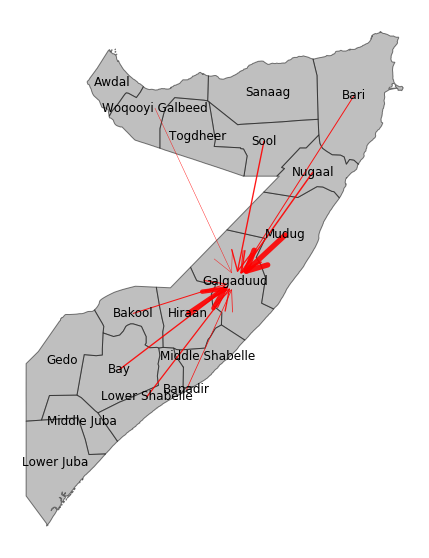

In [14]:
# Set the plot parameters
edgelist = [i for i in G.edges if i[1]=="Galgaduud"] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='grey', edgecolor="black", alpha=0.5)

#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.9, 
       node_color='None', edge_color='red', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=12) #, font_weight='bold')
plt.show()

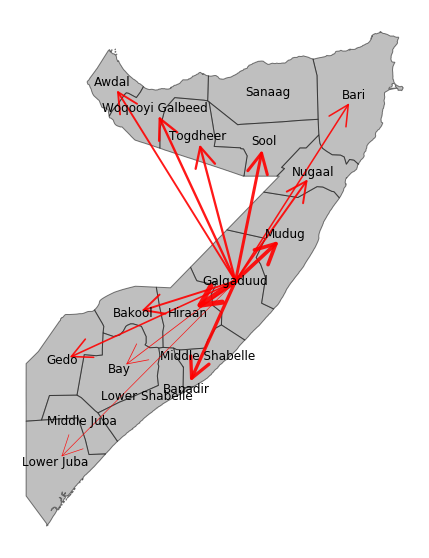

In [15]:
# Set the plot parameters
edgelist = [i for i in G.edges if i[0]=="Galgaduud"] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='grey', edgecolor="black", alpha=0.5)

#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.9, 
       node_color='None', edge_color='red', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=12) #, font_weight='bold')
plt.show()

In [16]:
shifted_pos = pos.copy()

for k,v in shifted_pos.items():
    pass #shifted_pos[k][1]+=.3

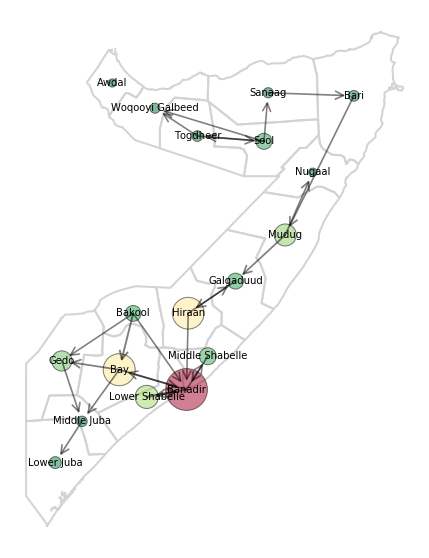

In [17]:
# Set the plot parameters
edgelist = [i for i in G.edges] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.1 
           if  G[i[0]][i[1]]['arrivals']>=100 else 0
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='None', edgecolor="lightgrey", linewidth=2)

#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.5, 
       node_color='None', edge_color='black', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos=shifted_pos, font_size=10, font_color="k") #, font_weight='bold')


pd.DataFrame(somalia_map).plot(x='centroid_x', y='centroid_y', kind='scatter', edgecolor="black", alpha=0.5,
                               c=(somalia_map['avg_arrivals']), s=(somalia_map['avg_arrivals']/10)**1.05, cmap='RdYlGn_r', colorbar=None,
                               ax=ax)
#plt.show()
plt.savefig("figures/network.png", dpi=100, bbox_inches="tight")

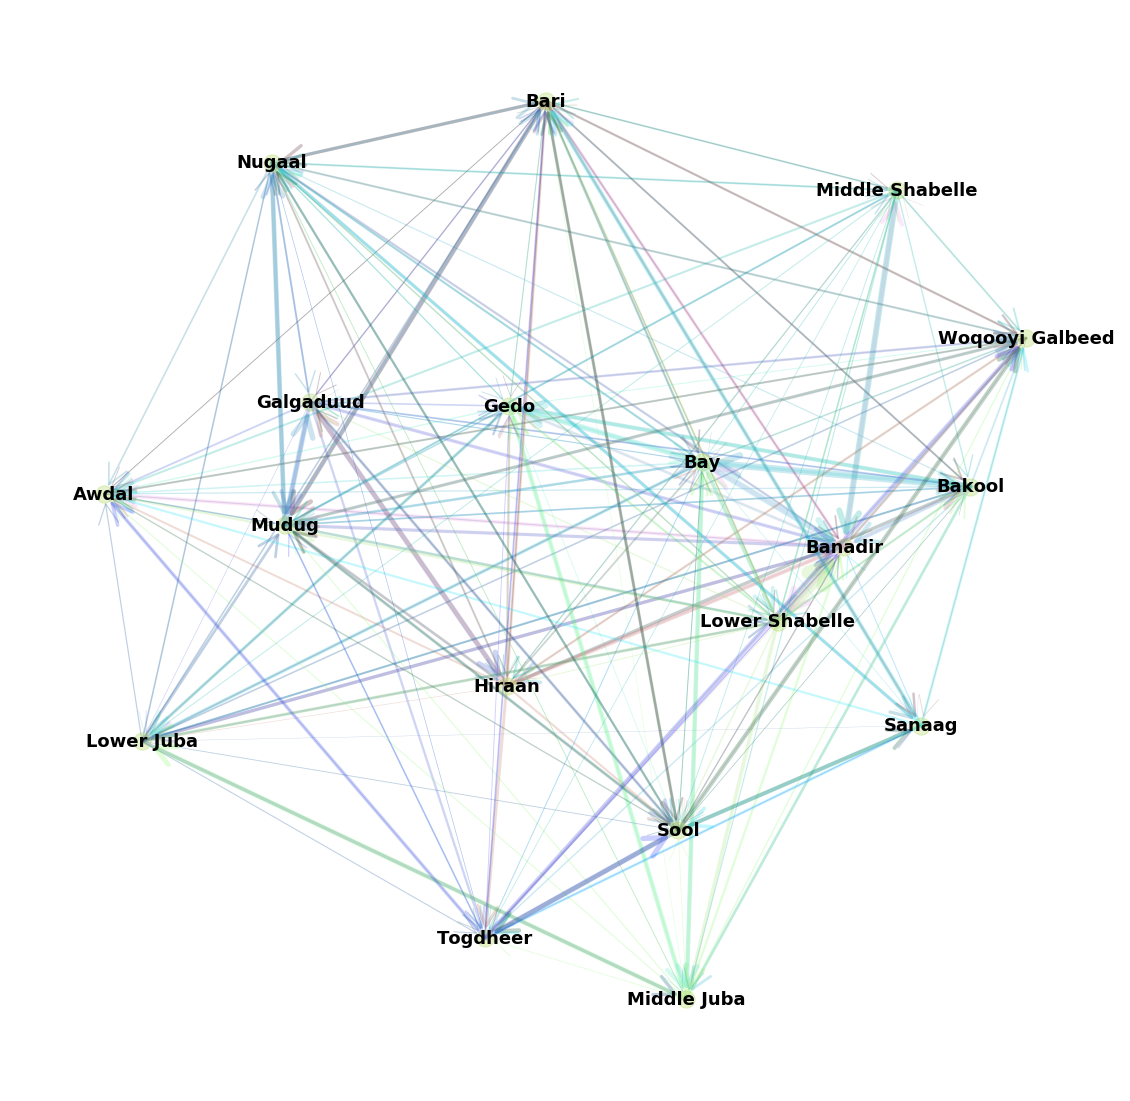

In [18]:
# Set the plot parameters
edgelist = G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 for i in G.edges]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[20,20])

pos = nx.spring_layout(G, weight='arrivals', k=8)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.25, 
       node_color='yellowgreen', edge_color=colors, with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=18, font_weight='bold')
plt.savefig("figures/network_spring.png", dpi=100, bbox_inches="tight")
plt.show()